# Midterm

In [18]:
import secrets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay
from scipy import stats

In [19]:
data_path = Path().resolve().parent / "data"

In [20]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [21]:
# Random seed for reproducibility
# secrets.randbits(128) # 208905213533139122735706682150229709525
rng = np.random.default_rng(208905213533139122735706682150229709525)
indices_train = rng.choice(5000, 2500, replace=False)
indices_test = rng.choice(800, 400, replace=False)
flag_full_dataset = True  # If it is True it will use full train and test datasets

In [22]:
train_list = []  # Auxiliary list of train datasets
for f in data_path.glob("train*.txt"):
    # Sample or full dataset
    raw_data = np.loadtxt(f) if flag_full_dataset else np.loadtxt(f)[indices_train, :]
    target = raw_data[:, [0]]  # Target values, i.e. digit
    features = raw_data[:, 1:] / raw_data[:, 1:].max(axis=1, keepdims=True)
    train_list.append(np.hstack((target, features)))  # Add to the temp list
train_data = np.vstack(train_list)  # Concatenate train datasets
train_data.shape

(60000, 785)

In [23]:
# Similar to train dataset
test_list = []
for f in data_path.glob("test*.txt"):
    raw_data = np.loadtxt(f) if flag_full_dataset else np.loadtxt(f)[indices_test, :]
    target = raw_data[:, [0]]
    features = raw_data[:, 1:] / raw_data[:, 1:].max(axis=1, keepdims=True)
    test_list.append(np.hstack((target, features)))
test_data = np.vstack(test_list)
test_data.shape

(10000, 785)

In [24]:
# Split datasets into features matrices and target vectors
rng.shuffle(train_data)
X_train = train_data[:, 1:]
y_train = train_data[:, 0].astype(int)
X_test = test_data[:, 1:]
y_test = test_data[:, 0].astype(int)

In [25]:
display(y_train[:5])
display(pd.get_dummies(y_train).head())

array([3, 3, 6, 2, 4])

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0


In [26]:
y_train_encoded = pd.get_dummies(y_train).to_numpy()
y_train_encoded

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

In [27]:
def forward(x, W_hidden, bias_hidden, W_output, bias_output):
    hidden = sigmoid(W_hidden @ x + bias_hidden)
    output = sigmoid(W_output @ hidden + bias_output)
    return hidden, output


def backward(x, target, W_hidden, bias_hidden, W_output, bias_output, hidden, output, eta):
    # Errors
    delta_output = output * (1 - output) * (target - output)
    delta_hidden = hidden * (1 - hidden) * W_output.T @ delta_output
    # Update
    D_W_hidden = eta * delta_hidden @ x.T
    D_bias_hidden = eta * delta_hidden
    D_W_output = eta * delta_output @ hidden.T
    D_bias_output = eta * delta_output
    W_hidden = W_hidden + D_W_hidden
    bias_hidden = bias_hidden + D_bias_hidden
    W_output = W_output + D_W_output
    bias_output = bias_output + D_bias_output
    return W_hidden, bias_hidden, W_output, bias_output

In [28]:
n_feature = X_train.shape[1]
n_output = np.unique(y_train).size  # Unique number of digits/classes
n_hidden = 10

eta = 0.05
init_min = -0.05
init_max = 0.05

In [29]:
# Initialization
W_hidden = np.random.uniform(init_min, init_max, size=(n_hidden, n_feature))
bias_hidden = np.random.uniform(init_min, init_max, size=(n_hidden, 1))
W_output = np.random.uniform(init_min, init_max, size=(n_output, n_hidden))
bias_output = np.random.uniform(init_min, init_max, size=(n_output, 1))
# Iteration
# for i in range(X_train.shape[0]):
n_iterations = 10000000
for j in range(n_iterations):
    i = j % n_feature
    if not j % 100000:
        print(f"Iteration: {j}")
    x = X_train[i:i + 1, :].T
    target = y_train_encoded[i:i + 1, :].T
    hidden, output = forward(x, W_hidden, bias_hidden, W_output, bias_output)
    # W_hidden_copy = np.copy(W_hidden)
    # bias_hidden_copy = np.copy(bias_hidden)
    # W_output_copy = np.copy(W_output)
    # bias_output_copy = np.copy(bias_output)
    W_hidden, bias_hidden, W_output, bias_output = backward(x, target, W_hidden, bias_hidden, W_output, bias_output, hidden, output, eta)

Iteration: 0


Iteration: 100000
Iteration: 200000
Iteration: 300000


KeyboardInterrupt: 

In [ ]:
# np.abs(W_hidden - W_hidden_copy).sum()

In [ ]:
y_pred = np.empty(shape=y_test.shape)
for i in range(X_test.shape[0]):
    _, pred = forward(X_test[i:i + 1, :].T, W_hidden, bias_hidden, W_output, bias_output)
    y_pred[i] = pred.argmax()

In [ ]:
n = y_pred.size
error_h = sum(y_pred == y_test) / n
sigma = np.sqrt(error_h * (1 - error_h) / n)
print(f"Accuracy was {error_h:.2%} and with approximately 95% probability the true error lies in the interval [{error_h - 1.96 * sigma:.4f}, {error_h + 1.96 * sigma:.4f}]")

Accuracy was 82.91% and with approximately 95% probability the true error lies in the interval [0.8217, 0.8365]


In [ ]:
# # Confusion matrix
# fig, ax = plt.subplots(figsize=(6, 6))
# ConfusionMatrixDisplay.from_predictions(
#     y_test,
#     y_pred,
#     ax=ax
# )
# fig.tight_layout()
# # fig.savefig(f"belief_confusion_matrix_fulldata_{flag_full_dataset}.png", dpi=300)
# fig.show()

/tmp/ipykernel_19298/1490769250.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


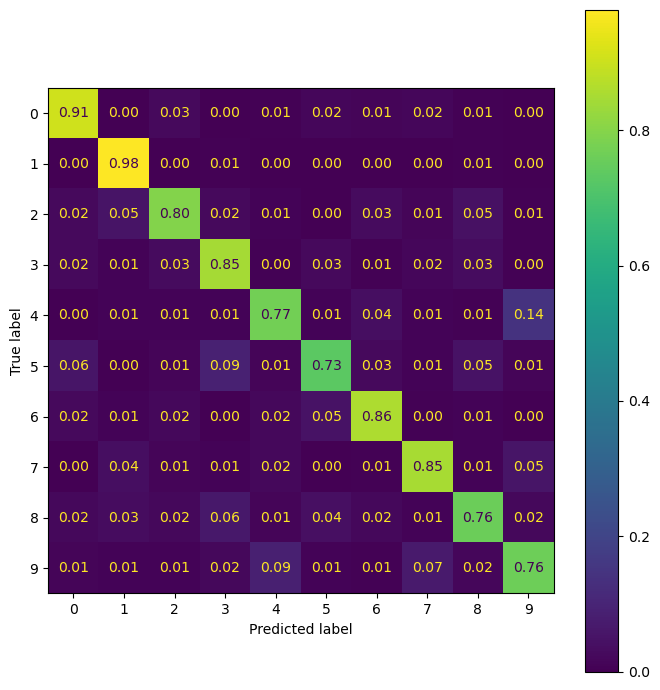

In [ ]:
# Confusion matrix - row normalization
fig, ax = plt.subplots(figsize=(7, 7))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    normalize="true",
    values_format=".2f",
    ax=ax
)
fig.tight_layout()
# fig.savefig(f"belief_confusion_matrix_row_normalize_fulldata_{flag_full_dataset}.png", dpi=300)
fig.show()